In [1]:
import pandas as pd
import calendar
import os

results_dir = r'C:\Users\justi\Downloads\CE634\CE634\results'
os.makedirs(results_dir, exist_ok=True)

taxi_columns = ["taxi_id", "pick_up_time", "drop_off_time", "pick_up_intersection", "drop_off_intersection"]
taxi_df = pd.read_csv(
    r'C:\Users\justi\Downloads\CE634\CE634\taxi_id.csv.bz2',
    compression='bz2',
    header=None,
    names=taxi_columns
)
intersection_to_zone_df = pd.read_csv(r'C:\Users\justi\Downloads\CE634\CE634\intersection_to_zone.csv')
inter_to_zone = dict(zip(intersection_to_zone_df['inter_id'], intersection_to_zone_df['zone_id']))
taxi_df["pick_up_zone"] = taxi_df["pick_up_intersection"].map(inter_to_zone)
taxi_df["drop_off_zone"] = taxi_df["drop_off_intersection"].map(inter_to_zone)

In [2]:
def get_time_period(ts):
    hour = pd.to_datetime(ts, unit='s').hour
    if 7 <= hour < 9:
        return 'morning'
    elif 16 <= hour < 18:
        return 'evening'
    else:
        return None

taxi_df["month"] = pd.to_datetime(taxi_df["pick_up_time"], unit='s').dt.month
taxi_df["period"] = taxi_df["pick_up_time"].apply(get_time_period)

In [3]:
scenarios = []

# 12 months
for month in range(1, 13):
    scenario_df = taxi_df[taxi_df["month"] == month]
    od_counts = (
        scenario_df
        .groupby(["pick_up_zone", "drop_off_zone"])
        .size()
        .reset_index(name="weight")
    )
    scenario_name = f"{calendar.month_abbr[month]}"    # Jan, Feb, ..., Dec
    full_path = os.path.join(results_dir, f"{scenario_name}_ODtoZone.csv")
    od_counts.to_csv(full_path, index=False)
    scenarios.append((scenario_name, od_counts))

# Whole year morning peak
morning_df = taxi_df[taxi_df["period"] == "morning"]
od_counts = (
    morning_df
    .groupby(["pick_up_zone", "drop_off_zone"])
    .size()
    .reset_index(name="weight")
)
scenario_name = "morning_peak"
full_path = os.path.join(results_dir, f"{scenario_name}_ODtoZone.csv")
od_counts.to_csv(full_path, index=False)
scenarios.append((scenario_name, od_counts))

# Whole year evening peak
evening_df = taxi_df[taxi_df["period"] == "evening"]
od_counts = (
    evening_df
    .groupby(["pick_up_zone", "drop_off_zone"])
    .size()
    .reset_index(name="weight")
)
scenario_name = "evening_peak"
full_path = os.path.join(results_dir, f"{scenario_name}_ODtoZone.csv")
od_counts.to_csv(full_path, index=False)
scenarios.append((scenario_name, od_counts))

In [4]:
from igraph import Graph

results_summary = []

for scenario_name, od_counts in scenarios:
    od_counts = od_counts.dropna(subset=['pick_up_zone', 'drop_off_zone'])
    od_counts['pick_up_zone'] = od_counts['pick_up_zone'].astype(int)
    od_counts['drop_off_zone'] = od_counts['drop_off_zone'].astype(int)
    G = Graph.DataFrame(od_counts, directed=False)
    communities = G.community_multilevel(weights=G.es['weight'])
    modularity = G.modularity(communities, weights=G.es['weight'])

    zone_membership = pd.DataFrame({
        "zone_index": G.vs.indices,
        "community": communities.membership
    })
    zone_csv_path = os.path.join(results_dir, f"{scenario_name}_communities.csv")
    zone_membership.to_csv(zone_csv_path, index=False)

    results_summary.append({
        "Scenario": scenario_name,
        "NumCommunities": len(communities),
        "Modularity": modularity
    })
    print(f"Scenario {scenario_name}: Communities={len(communities)}, Modularity={modularity:.4f}")

summary_df = pd.DataFrame(results_summary)
community_summary_path = os.path.join(results_dir, "community_summary.csv")
summary_df.to_csv(community_summary_path, index=False)
print("\n--- All 14 scenarios processed successfully ---")
print(summary_df)

Scenario Jan: Communities=205, Modularity=0.2027
Scenario Feb: Communities=204, Modularity=0.1956
Scenario Mar: Communities=205, Modularity=0.1898
Scenario Apr: Communities=205, Modularity=0.1880
Scenario May: Communities=205, Modularity=0.1853
Scenario Jun: Communities=204, Modularity=0.1815
Scenario Jul: Communities=205, Modularity=0.1715
Scenario Aug: Communities=204, Modularity=0.1722
Scenario Sep: Communities=204, Modularity=0.1876
Scenario Oct: Communities=205, Modularity=0.1846
Scenario Nov: Communities=204, Modularity=0.1865
Scenario Dec: Communities=205, Modularity=0.1949
Scenario morning_peak: Communities=205, Modularity=0.1689
Scenario evening_peak: Communities=205, Modularity=0.2164

--- All 14 scenarios processed successfully ---
        Scenario  NumCommunities  Modularity
0            Jan             205    0.202717
1            Feb             204    0.195579
2            Mar             205    0.189752
3            Apr             205    0.188048
4            May      

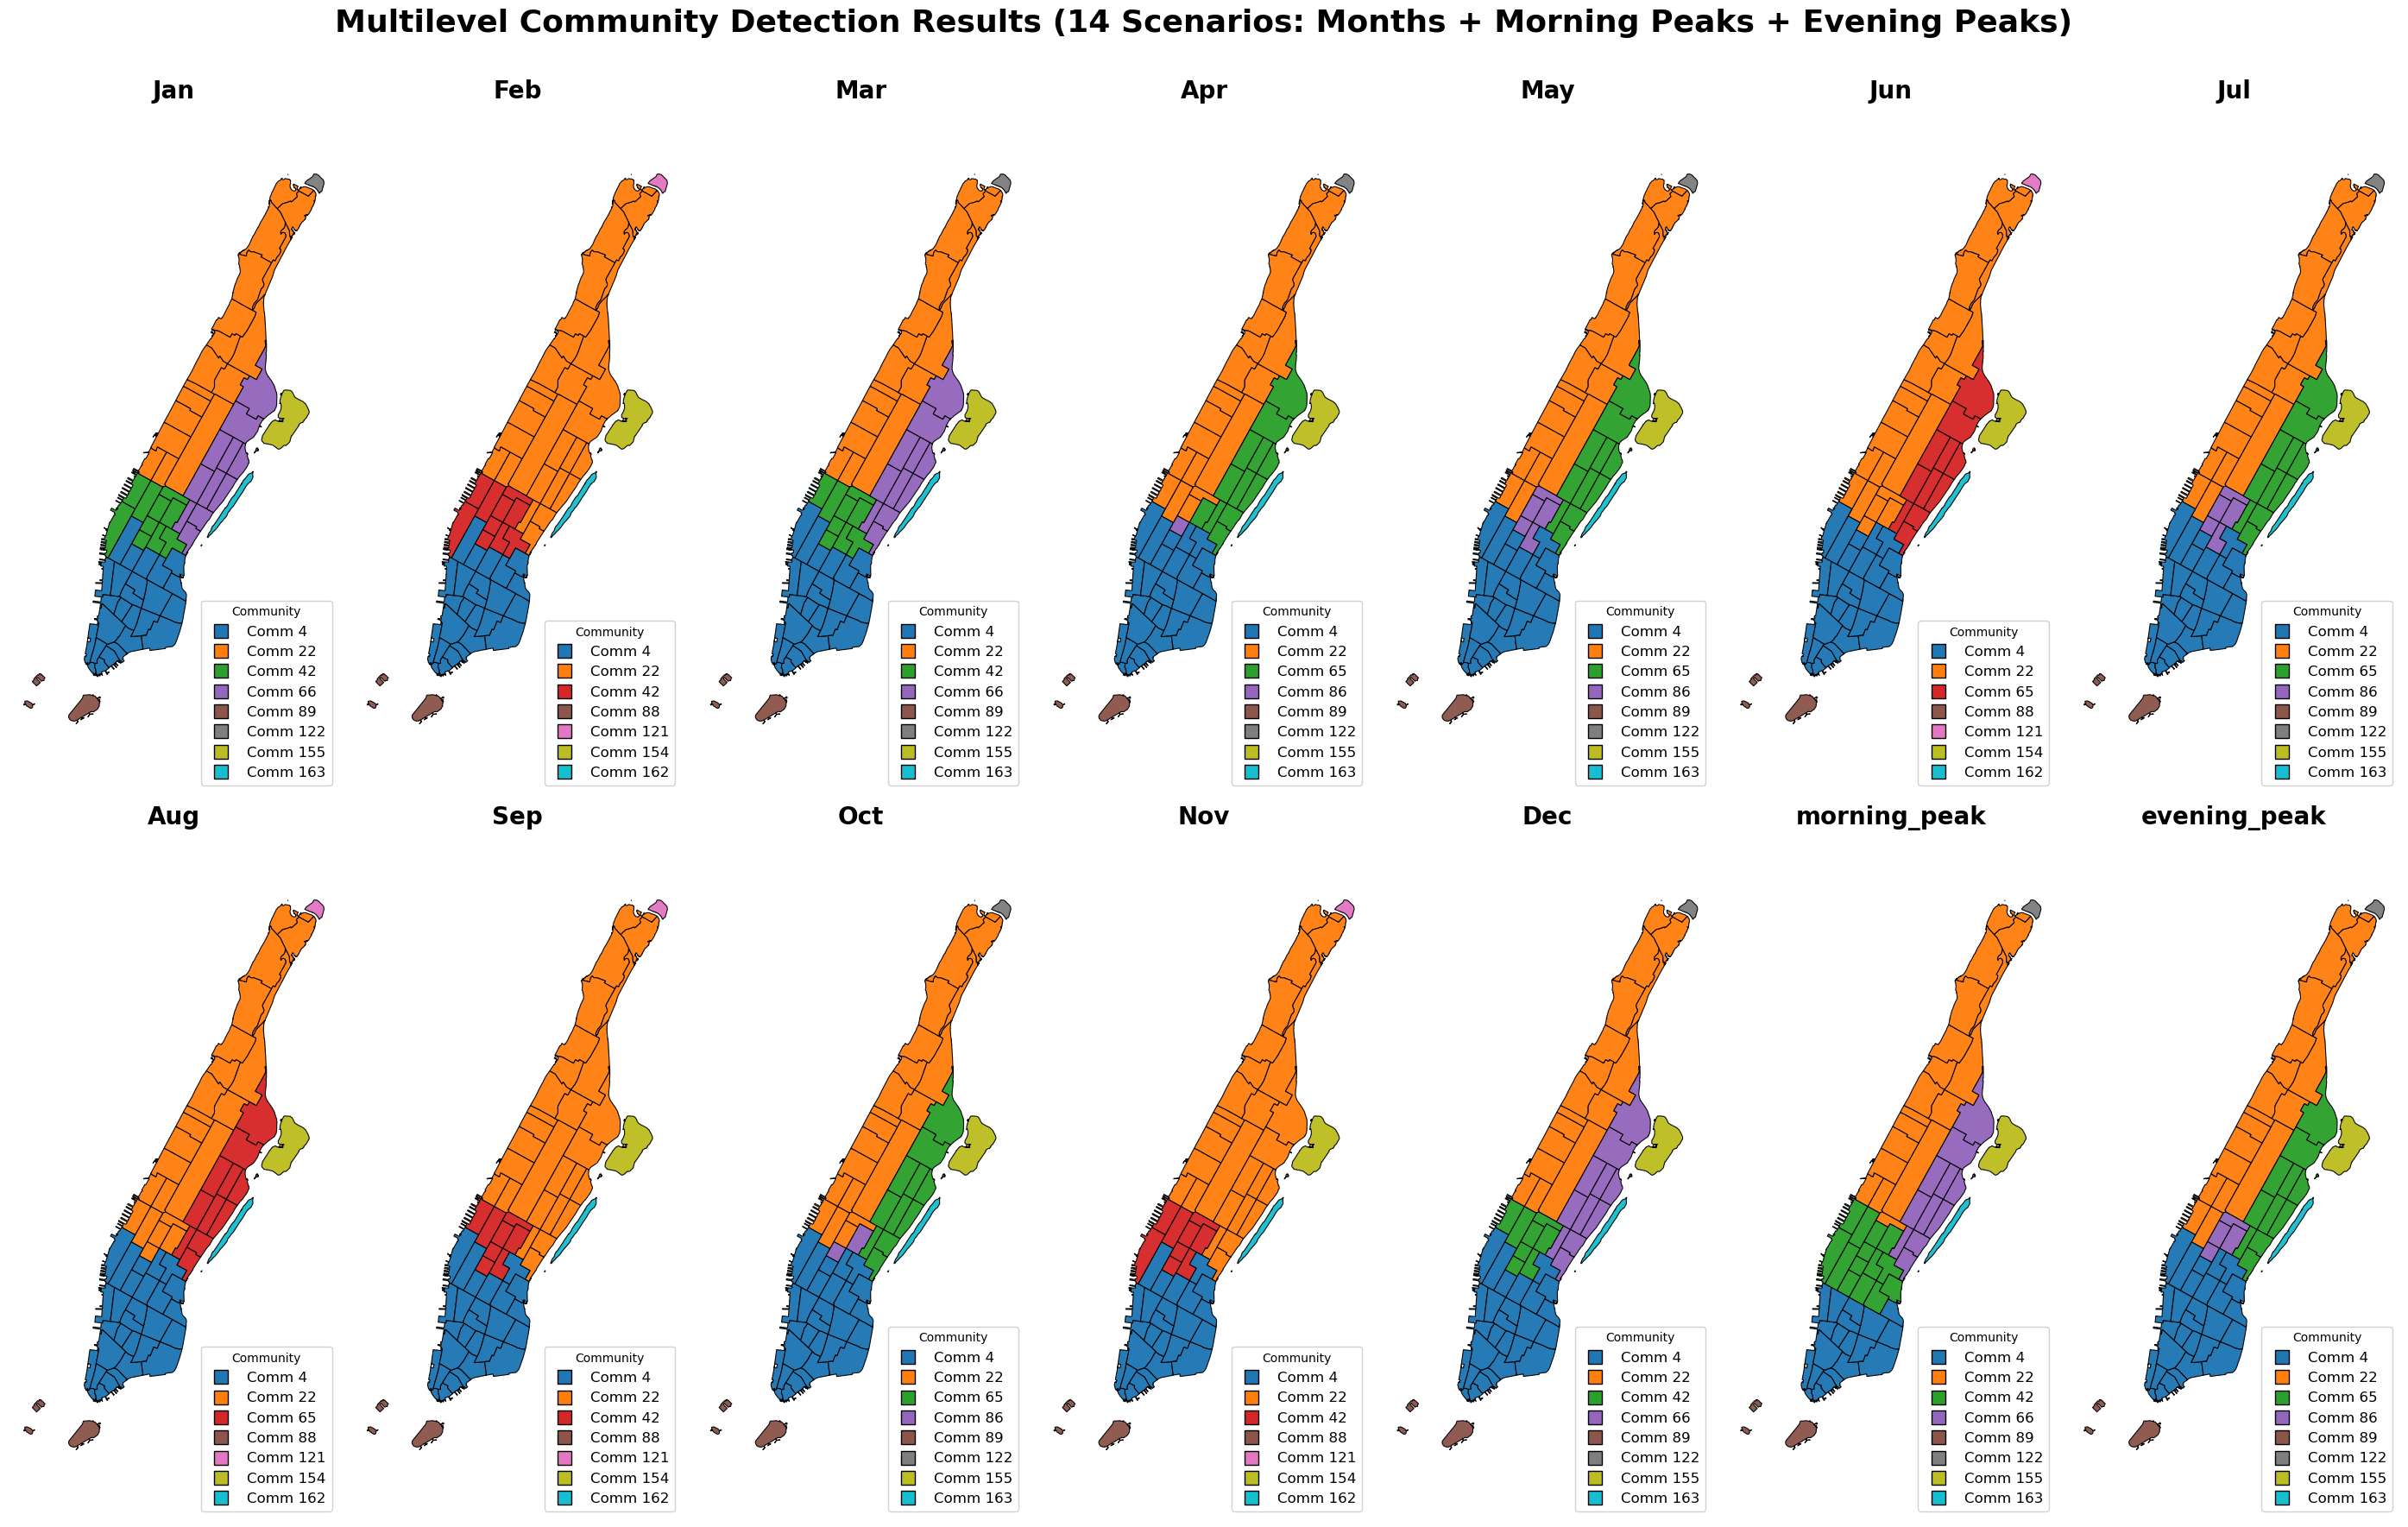

In [25]:
import shapefile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')

results_dir = r'C:\Users\justi\Downloads\CE634\CE634\results'
shp_path = os.path.join(results_dir, 'NYC_M_Polygon.shp')
zone_col_in_shp = 'LocationID'

scenario_names = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul",
    "Aug", "Sep", "Oct", "Nov", "Dec", "morning_peak", "evening_peak"
]

def get_dbf_fieldnames(sf):
    return [f[0] for f in sf.fields[1:]]

def extract_community_map(comm_df):
    comm_col = 'zone_index' if 'zone_index' in comm_df.columns else 'zone_id'
    comm_df = comm_df.rename(columns={comm_col: 'zone_id'})
    return dict(zip(comm_df['zone_id'], comm_df['community']))

# Load shapefile once for performance
sf = shapefile.Reader(shp_path)
fields = get_dbf_fieldnames(sf)
zone_idx = fields.index(zone_col_in_shp)
polys = sf.shapes()
records = sf.records()
zone_ids = [rec[zone_idx] for rec in records]

fig, axes = plt.subplots(2, 7, figsize=(28, 18))
plt.subplots_adjust(wspace=0.08, hspace=0.18)

for idx, scenario_name in enumerate(scenario_names):
    ax = axes.flatten()[idx]
    csv_path = os.path.join(results_dir, f"{scenario_name}_communities.csv")
    if not os.path.exists(csv_path):
        ax.set_title(f"{scenario_name} (missing)", fontsize=20, fontweight='bold', color='red')
        ax.axis('off')
        continue

    comm_df = pd.read_csv(csv_path)
    comm_map = extract_community_map(comm_df)
    comm_labels = [comm_map.get(zid, -1) for zid in zone_ids]
    unique_comms = sorted(set(comm_labels) - {-1})
    color_map = {c: plt.cm.get_cmap('tab10', len(unique_comms))(i) for i, c in enumerate(unique_comms)}

    for i, shape in enumerate(polys):
        comm = comm_labels[i]
        color = color_map[comm] if comm != -1 else 'lightgrey'
        points = np.array(shape.points)
        parts = list(shape.parts) + [len(points)]
        for j in range(len(parts) - 1):
            polygon = points[parts[j]:parts[j + 1]]
            ax.fill(polygon[:, 0], polygon[:, 1], color=color, linewidth=0.8, edgecolor='black', alpha=0.97)

    handles = [plt.Line2D([0], [0], marker='s', color='w', label=f'Comm {c}',
                          markerfacecolor=color_map[c], markersize=12, markeredgecolor='black')
               for c in unique_comms]
    legend = ax.legend(handles=handles, loc='lower right', frameon=True, fontsize=12, title='Community')
    legend.get_frame().set_alpha(0.9)

    # >>> Bigger, bold subtitle <<<
    ax.set_title(scenario_name, fontsize=20, fontweight='bold')
    ax.axis('equal')
    ax.axis('off')

fig.suptitle('Multilevel Community Detection Results (14 Scenarios: Months + Morning Peaks + Evening Peaks)', fontsize=26, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig("Fig_1.png", dpi=300, bbox_inches='tight')
plt.show()